This notebook has service times not tied to jobs, and we compare the results of the simulation to the expected/theoretical results and see avg queue length vs. thresholds.

We confirm that the results hold for different values of lambda, mu1, mu2, and surge thresholds to ensure that our model is functioning correctly.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "arrival_time")
# example: c = Customer(service_time = 1, arrival_time = 0.5, patience_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

In [3]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# surge_threshold = the queue length to activate surge at
# c = number of servers (1)
# N0 = starting number in the queue
# Tmax = time horizon

def MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    
    
    # customers currently being served by a server
    servers = [customer(0) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(0) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        event_rate = lambd + mu1*(0 < N[-1] and N[-1] < surge_threshold) + mu2*(surge_threshold <= N[-1])
        next_event = exp(event_rate)
        T.append(t_temp + next_event)
        event = rand()
            
        ##### ARRIVAL ##### 
        if event < lambd / event_rate:
            N.append(N[-1] + 1) 
            if len(servers) < c:
                servers.append(customer(T[-1]))
            else:
                queue.append(customer(T[-1]))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(customer(next_to_enter.arrival_time))
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta

    S = S / (T[-1] - start_measuring_surge)
    in_surge = in_surge / (T[-1] - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

Simulation average queue length (calculated after method): 2.869415
Simulation p_surge (calculated after method): 0.190856
Simulation average queue length (calculated within method): 2.865979
Simulation p_surge (calculated within method): 0.190376
Expected average queue length: 2.803739
Expected p_surge: 0.180438
Difference between simulation and theoretical average queue length: 0.065676
Difference between simulation and theoretical average queue length: 0.062240
Difference between simulation and theoretical p(surge): 0.010417
Difference between simulation and theoretical p(surge): 0.009938


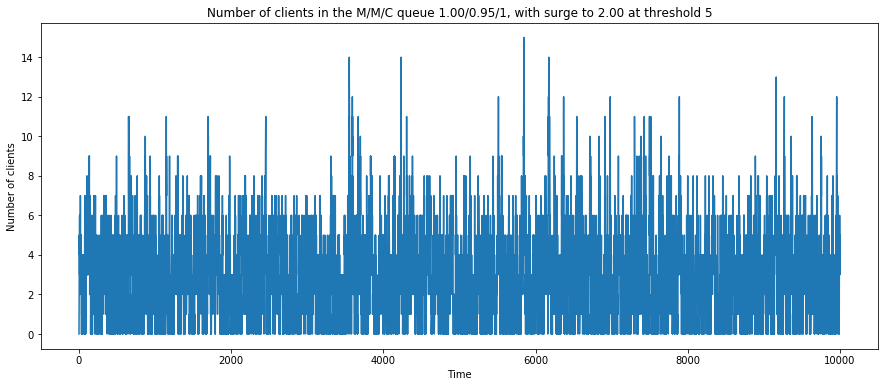

In [4]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
surge_threshold = 5
c = 1
N0 = 0
Tmax = 10**4

T, N, W, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at threshold %d'
      % (lambd, mu1, c, mu2, surge_threshold))

T_diff = [(T[i+1] - T[i]) for i in range(len(T) - 1)]
t_max = T_diff[-1]
t_tenth = T_diff[1000]
Q_sim = np.dot(T_diff[1000:], N[1000:-1]) / (T[-1] - T[1000])
print("Simulation average queue length (calculated after method): %f" % (Q_sim))

N_surge = [1*(N[i] >= surge_threshold) for i in range(len(N))]
p_surge_sim = np.dot(T_diff[1000:], N_surge[1000:-1]) / (T[-1] - T[1000])
print("Simulation p_surge (calculated after method): %f" % (p_surge_sim))

print("Simulation average queue length (calculated within method): %f" % (S))
print("Simulation p_surge (calculated within method): %f" % (in_surge))

coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 1000)]
pi0 = 1 / (sum(coefs))
pis = [coefs[i] * pi0 for i in range(len(coefs))]
Q_expected = sum([i * pis[i] for i in range(len(pis))])
p_expected = sum(pis[surge_threshold:])
print("Expected average queue length: %f" % (Q_expected))
print("Expected p_surge: %f" % (p_expected))

print("Difference between simulation and theoretical average queue length: %f" % (Q_sim - Q_expected))
print("Difference between simulation and theoretical average queue length: %f" % (S - Q_expected))
print("Difference between simulation and theoretical p(surge): %f" % (p_surge_sim - p_expected))
print("Difference between simulation and theoretical p(surge): %f" % (in_surge - p_expected))

Simulation average queue length (calculated after method): 7.119407
Simulation p_surge (calculated after method): 0.346392
Simulation average queue length (calculated within method): 7.114594
Simulation p_surge (calculated within method): 0.344733
Expected average queue length: 7.023499
Expected p_surge: 0.334204
Difference between simulation and theoretical average queue length: 0.095908
Difference between simulation and theoretical average queue length: 0.091095
Difference between simulation and theoretical p(surge): 0.012188
Difference between simulation and theoretical p(surge): 0.010529


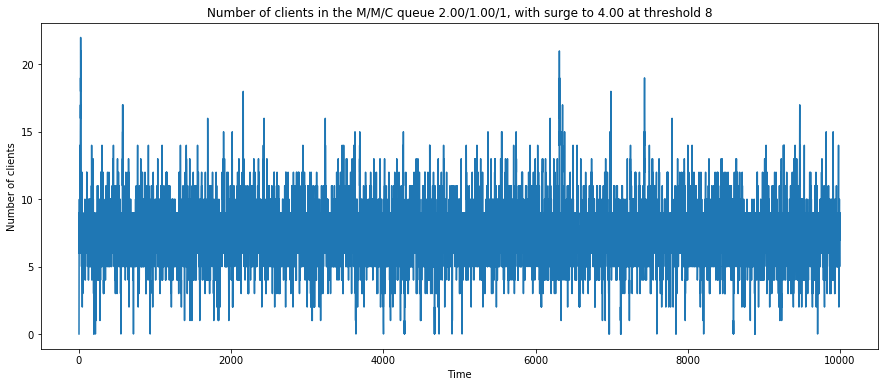

In [5]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 2
mu1 = 1
mu2 = 4
surge_threshold = 8
c = 1
N0 = 0
Tmax = 10**4

T, N, W, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at threshold %d'
      % (lambd, mu1, c, mu2, surge_threshold))

T_diff = [(T[i+1] - T[i]) for i in range(len(T) - 1)]
t_max = T_diff[-1]
t_tenth = T_diff[1000]
Q_sim = np.dot(T_diff[1000:], N[1000:-1]) / (T[-1] - T[1000])
print("Simulation average queue length (calculated after method): %f" % (Q_sim))

N_surge = [1*(N[i] >= surge_threshold) for i in range(len(N))]
p_surge_sim = np.dot(T_diff[1000:], N_surge[1000:-1]) / (T[-1] - T[1000])
print("Simulation p_surge (calculated after method): %f" % (p_surge_sim))

print("Simulation average queue length (calculated within method): %f" % (S))
print("Simulation p_surge (calculated within method): %f" % (in_surge))

coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 1000)]
pi0 = 1 / (sum(coefs))
pis = [coefs[i] * pi0 for i in range(len(coefs))]
Q_expected = sum([i * pis[i] for i in range(len(pis))])
p_expected = sum(pis[surge_threshold:])
print("Expected average queue length: %f" % (Q_expected))
print("Expected p_surge: %f" % (p_expected))

print("Difference between simulation and theoretical average queue length: %f" % (Q_sim - Q_expected))
print("Difference between simulation and theoretical average queue length: %f" % (S - Q_expected))
print("Difference between simulation and theoretical p(surge): %f" % (p_surge_sim - p_expected))
print("Difference between simulation and theoretical p(surge): %f" % (in_surge - p_expected))

Simulation average queue length (calculated after method): 7.074814
Simulation p_surge (calculated after method): 0.344244
Simulation average queue length (calculated within method): 7.079356
Simulation p_surge (calculated within method): 0.344468
Expected average queue length: 7.023499
Expected p_surge: 0.334204
Difference between simulation and theoretical average queue length: 0.051315
Difference between simulation and theoretical average queue length: 0.055858
Difference between simulation and theoretical p(surge): 0.010040
Difference between simulation and theoretical p(surge): 0.010264


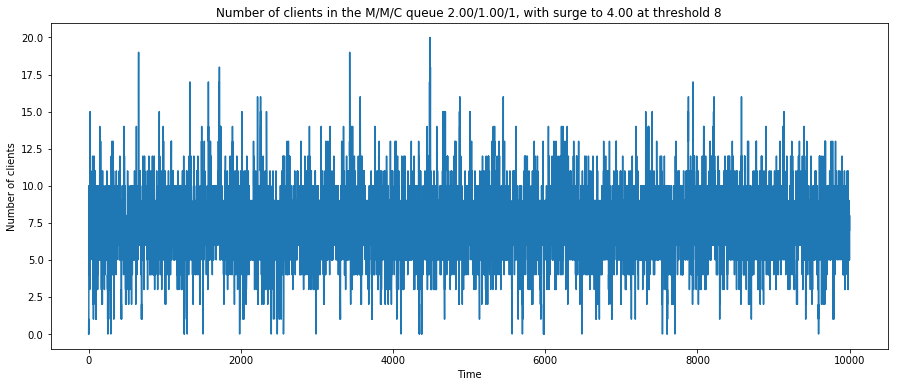

In [6]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 2
mu1 = 1
mu2 = 4
surge_threshold = 8
c = 1
N0 = 0
Tmax = 10**4

T, N, W, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at threshold %d'
      % (lambd, mu1, c, mu2, surge_threshold))

T_diff = [(T[i+1] - T[i]) for i in range(len(T) - 1)]
t_max = T_diff[-1]
t_tenth = T_diff[1000]
Q_sim = np.dot(T_diff[1000:], N[1000:-1]) / (T[-1] - T[1000])
print("Simulation average queue length (calculated after method): %f" % (Q_sim))

N_surge = [1*(N[i] >= surge_threshold) for i in range(len(N))]
p_surge_sim = np.dot(T_diff[1000:], N_surge[1000:-1]) / (T[-1] - T[1000])
print("Simulation p_surge (calculated after method): %f" % (p_surge_sim))

print("Simulation average queue length (calculated within method): %f" % (S))
print("Simulation p_surge (calculated within method): %f" % (in_surge))

coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 1000)]
pi0 = 1 / (sum(coefs))
pis = [coefs[i] * pi0 for i in range(len(coefs))]
Q_expected = sum([i * pis[i] for i in range(len(pis))])
p_expected = sum(pis[surge_threshold:])
print("Expected average queue length: %f" % (Q_expected))
print("Expected p_surge: %f" % (p_expected))

print("Difference between simulation and theoretical average queue length: %f" % (Q_sim - Q_expected))
print("Difference between simulation and theoretical average queue length: %f" % (S - Q_expected))
print("Difference between simulation and theoretical p(surge): %f" % (p_surge_sim - p_expected))
print("Difference between simulation and theoretical p(surge): %f" % (in_surge - p_expected))

In [7]:
# now, see how threshold affects queue length 

lambd = 4
mu1 = 3
mu2 = 8
c = 1
N0 = 0
Tmax = 10**4

threshold = []
avg_queue_len = []
p_surge = []

for surge_threshold in range(2, 15):
    _,_,_, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
    threshold.append(surge_threshold)
    
    coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 1000)]
    pi0 = 1 / (sum(coefs))
    pis = [coefs[i] * pi0 for i in range(len(coefs))]
    Q_expected = sum([i * pis[i] for i in range(len(pis))])
    p_expected = sum(pis[surge_threshold:])
    avg_queue_len.append(S - Q_expected)
    p_surge.append(in_surge - p_expected)

Text(0.5,1,'Difference between Simulation and Theoretical Average Queue Length in the M/M/C queue 4.00/3.00/1, with surge to 8.00 at different thresholds')

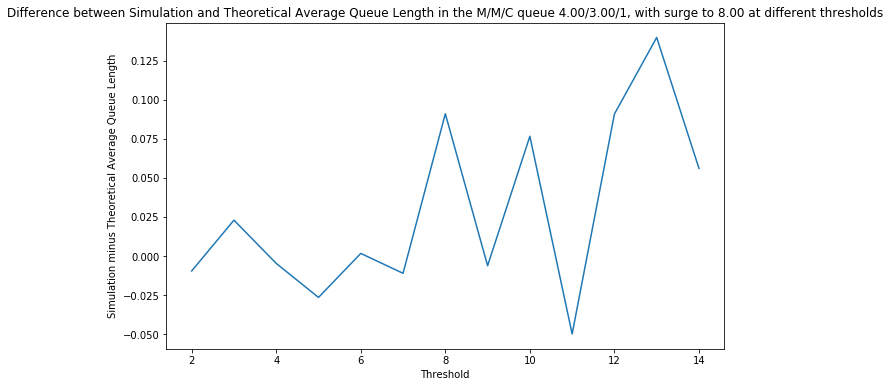

In [8]:
figure(figsize=(10,6))
plot(threshold, avg_queue_len)
xlabel('Threshold')
ylabel('Simulation minus Theoretical Average Queue Length')
title('Difference between Simulation and Theoretical Average Queue Length in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at different thresholds' % (lambd, mu1, c, mu2))

Text(0.5,1,'Difference between Simulation and Theoretical Average p_surge in the M/M/C queue 4.00/3.00/1, with surge to 8.00 at different thresholds')

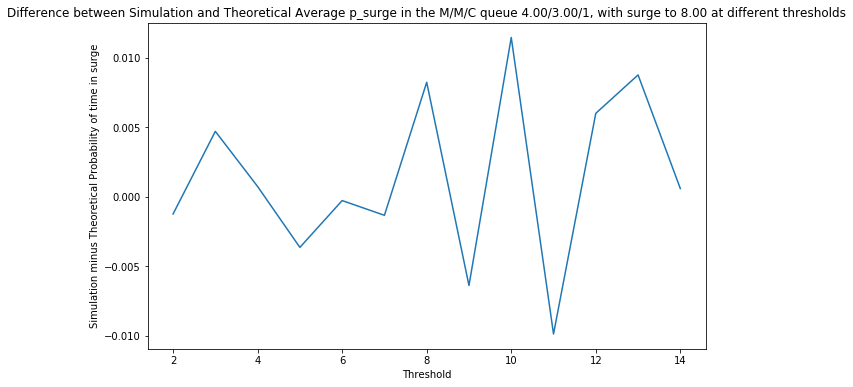

In [9]:
figure(figsize=(10,6))
plot(threshold, p_surge)
xlabel('Threshold')
ylabel('Simulation minus Theoretical Probability of time in surge')
title('Difference between Simulation and Theoretical Average p_surge in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at different thresholds' % (lambd, mu1, c, mu2))

The above graphs do not follow any pattern, which reflects the intuition that the variation between simulation and theoretical is due to stochastic fluctuations.

In [10]:
# now, see how threshold affects queue length 

lambd = 4
mu1 = 3
surge_threshold = 6
c = 1
N0 = 0
Tmax = 10**4

mu2s = []
avg_queue_len = []
p_surge = []

for mu2 in range(5, 25):
    _,_,_, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
    mu2s.append(mu2)
    
    coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 1000)]
    pi0 = 1 / (sum(coefs))
    pis = [coefs[i] * pi0 for i in range(len(coefs))]
    Q_expected = sum([i * pis[i] for i in range(len(pis))])
    p_expected = sum(pis[surge_threshold:])
    avg_queue_len.append(S - Q_expected)
    p_surge.append(in_surge - p_expected)

Text(0.5,1,'Difference between Simulation and Theoretical Average Queue Length in the M/M/C queue 4.00/3.00/1, with surge at 6 to different mu2s')

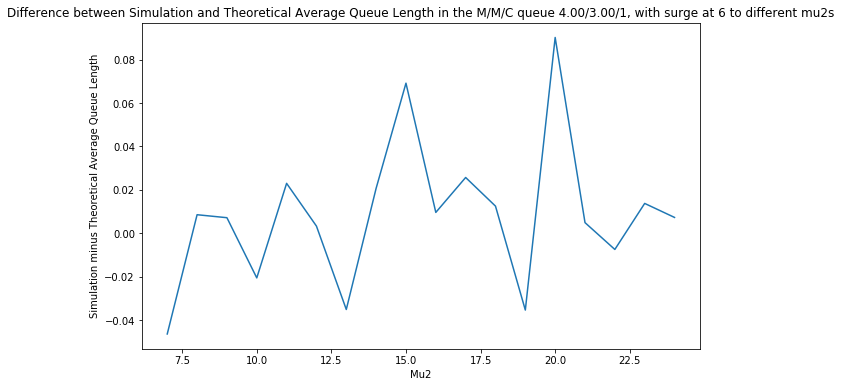

In [11]:
figure(figsize=(10,6))
plot(mu2s[2:], avg_queue_len[2:])
xlabel('Mu2')
ylabel('Simulation minus Theoretical Average Queue Length')
title('Difference between Simulation and Theoretical Average Queue Length in the M/M/C queue %.2f/%.2f/%d, with surge at %d to different mu2s' % (lambd, mu1, c, surge_threshold))

Again, this graph does not follow any pattern, which reflects the intuition that the variation between simulation and theoretical is due to stochastic fluctuations.